# 1. Импорты

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib.patches import Ellipse
from EM import GMM

# Настройка стиля графиков
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# 2. Генерация данных

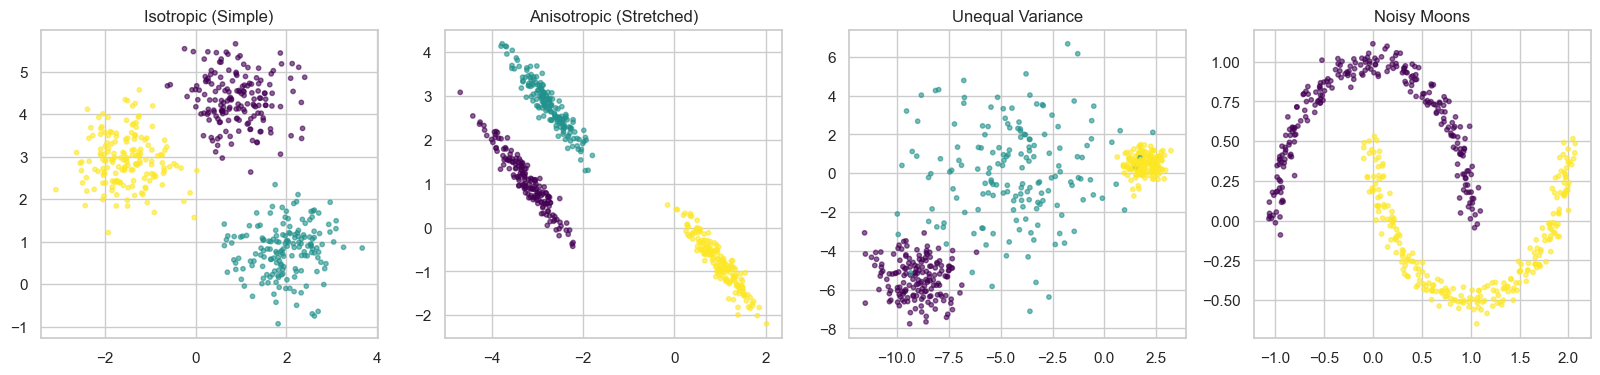

In [2]:
def generate_datasets(n_samples=500):
    datasets = {}
    
    # 1. Идеальные кластеры (Сферические, равные)
    X_iso, y_iso = make_blobs(n_samples=n_samples, centers=3, cluster_std=0.60, random_state=0)
    datasets['Isotropic (Simple)'] = (X_iso, y_iso)
    
    # 2. Анизотропные (Вытянутые диагонально)
    # Берем обычные и умножаем на трансформирующую матрицу
    X_aniso, y_aniso = make_blobs(n_samples=n_samples, centers=3, cluster_std=0.60, random_state=170)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X_aniso, transformation)
    datasets['Anisotropic (Stretched)'] = (X_aniso, y_aniso)
    
    # 3. Разная дисперсия (Один плотный, другие рыхлые)
    X_var, y_var = make_blobs(n_samples=n_samples, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=170)
    datasets['Unequal Variance'] = (X_var, y_var)
    
    # 4. Невыпуклые (Луны) - Сложный случай для GMM и Kmeans
    X_moon, y_moon = make_moons(n_samples=n_samples, noise=0.05, random_state=0)
    datasets['Noisy Moons'] = (X_moon, y_moon)
    
    return datasets

data_dict = generate_datasets()

# Визуализация сырых данных
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i, (name, (X, y)) in enumerate(data_dict.items()):
    axes[i].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='viridis', alpha=0.6)
    axes[i].set_title(name)
plt.show()

# 3. Функция отрисовки эллипсов и результатов

In [18]:
# === ФУНКЦИЯ ОТРИСОВКИ (Общая для всех ячеек) ===
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Рисует эллипс ковариации (доверительный интервал)"""
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2, 2
    for nsig in range(1, 3):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                             angle=angle, **kwargs, alpha=0.2/nsig))

def analyze_dataset_with_k_range(X, y_true, k_values, dataset_name):
    """
    Запускает GMM и KMeans для списка разных K и рисует результаты.
    """
    rows = len(k_values)
    cols = 2 # KMeans vs GMM
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    plt.suptitle(f"Анализ датасета: {dataset_name}", fontsize=16, y=1.02)
    
    # Если всего одна строка (один K), axes будет 1D массивом, исправляем
    if rows == 1: axes = np.array([axes])

    for i, k in enumerate(k_values):
        print(f"Запуск для K={k}...")
        
        # --- 1. KMeans ---
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        y_km = km.fit_predict(X)
        ari_km = adjusted_rand_score(y_true, y_km)
        
        ax_km = axes[i, 0]
        ax_km.scatter(X[:, 0], X[:, 1], c=y_km, s=15, cmap='viridis', alpha=0.7)
        ax_km.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='red', marker='x', s=100)
        ax_km.set_title(f"K-Means (K={k})\nARI: {ari_km:.3f}")
        
        # --- 2. GMM ---
        gmm = GMM(n_components=k, max_iter=100, tol=1e-4, kmeans_start=True)
        gmm.fit(X)
        y_gmm = gmm.predict(X)
        ari_gmm = adjusted_rand_score(y_true, y_gmm)
        
        ax_gmm = axes[i, 1]
        ax_gmm.scatter(X[:, 0], X[:, 1], c=y_gmm, s=15, cmap='viridis', alpha=0.7)
        
        # Рисуем эллипсы
        for cluster_idx in range(gmm.K):
            if gmm.weights[cluster_idx] > 0.001:
                draw_ellipse(gmm.means[cluster_idx], gmm.covs[cluster_idx], ax=ax_gmm, color='red')
        
        ax_gmm.set_title(f"GMM (K={k})\nARI: {ari_gmm:.3f} | LL: {gmm.log_likelihood_history[-1]:.1f}")

    plt.tight_layout()
    plt.show()

# 4. Основной цикл экспериментов

<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
C:\Users\PC\AppData\Local\Temp\ipykernel_22476\2072481774.py:70: SyntaxWarning: invalid escape sequence '\m'
  label=f'Комп. {k+1} ($\mu$={mu:.1f})')


==================== РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА ====================

--- Вариант: 2 предполагаемых кластера ---
  Кластер 1: Вес=0.22, Центр=5.60, Sigma=1.26
  Кластер 2: Вес=0.78, Центр=-1.53, Sigma=3.07

--- Вариант: 3 предполагаемых кластера ---
  Кластер 1: Вес=0.30, Центр=5.13, Sigma=1.51
  Кластер 2: Вес=0.30, Центр=-4.99, Sigma=0.96
  Кластер 3: Вес=0.40, Центр=0.03, Sigma=0.59


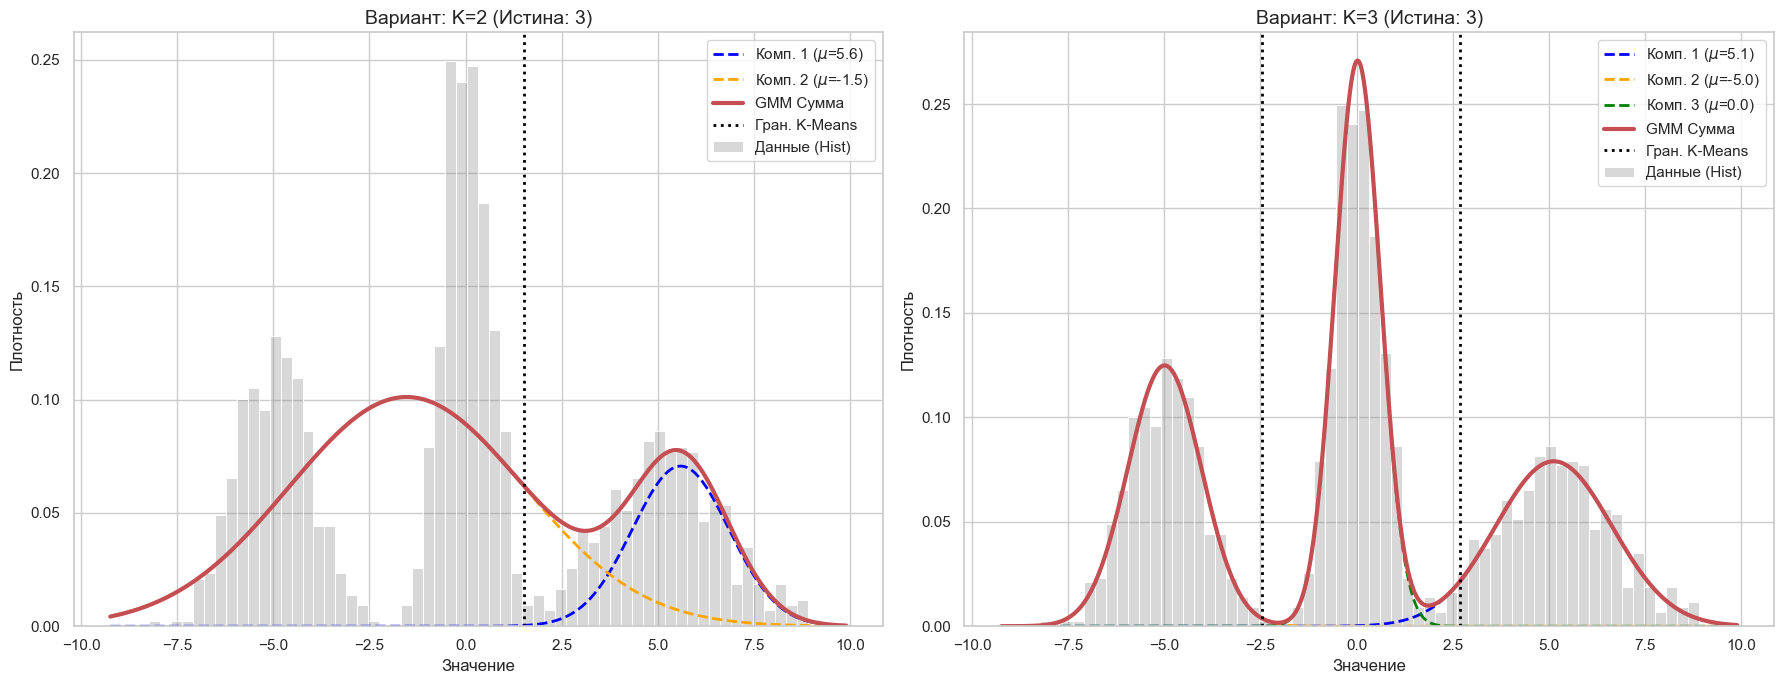

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans # На случай, если не импортировано

# 1. ГЕНЕРАЦИЯ 1D ДАННЫХ (3 КЛАСТЕРА)
np.random.seed(42)
n_samples = 1500

# Кластер 1: Слева (центр -5)
X1 = np.random.normal(-5, 1.0, int(n_samples * 0.3))
# Кластер 2: Центр (центр 0, узкий)
X2 = np.random.normal(0, 0.6, int(n_samples * 0.4))
# Кластер 3: Справа (центр 5, широкий)
X3 = np.random.normal(5, 1.5, int(n_samples * 0.3))

# Объединяем и решейпим
X_1d = np.concatenate([X1, X2, X3]).reshape(-1, 1)

# Настройки эксперимента
n_components_variants = [2, 3] # Два варианта эксперимента
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # Два графика рядом

x_axis = np.linspace(X_1d.min()-1, X_1d.max()+1, 1000)

print(f"{'='*20} РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА {'='*20}")

for idx, n_comp in enumerate(n_components_variants):
    ax = axes[idx]
    
    # --- 2. ОБУЧЕНИЕ ---
    
    # GMM (Ваш класс)
    # Важно: предполагается, что ваш класс поддерживает параметр n_components
    gmm = GMM(n_components=n_comp, max_iter=100, kmeans_start=True)
    gmm.fit(X_1d)
    
    # K-Means (для сравнения)
    kmeans = KMeans(n_clusters=n_comp, n_init=10, random_state=42)
    kmeans.fit(X_1d)
    
    # Расчет границ K-Means (обобщенный метод для любого числа кластеров)
    # 1. Сортируем центры
    sorted_centers = np.sort(kmeans.cluster_centers_.ravel())
    # 2. Границы - это середины между соседними центрами
    km_boundaries = [(sorted_centers[i] + sorted_centers[i+1])/2 for i in range(len(sorted_centers)-1)]

    # --- 3. ВИЗУАЛИЗАЦИЯ ---
    
    # А. Гистограмма данных
    sns.histplot(X_1d.ravel(), bins=60, stat='density', alpha=0.3, color='gray', label='Данные (Hist)', ax=ax)
    
    # Б. Визуализация GMM
    gmm_sum = np.zeros_like(x_axis)
    colors = ['blue', 'orange', 'green'] # Цвета для компонентов
    
    print(f"\n--- Вариант: {n_comp} предполагаемых кластера ---")
    
    for k in range(gmm.K):
        w = gmm.weights[k]
        mu = gmm.means[k, 0]
        sigma = np.sqrt(gmm.covs[k, 0, 0])
        
        y_axis = w * norm.pdf(x_axis, mu, sigma)
        gmm_sum += y_axis
        
        # Рисуем отдельную компоненту
        ax.plot(x_axis, y_axis, '--', linewidth=2, color=colors[k % len(colors)], 
                label=f'Комп. {k+1} ($\mu$={mu:.1f})')
        
        print(f"  Кластер {k+1}: Вес={w:.2f}, Центр={mu:.2f}, Sigma={sigma:.2f}")

    # Рисуем сумму (модель)
    ax.plot(x_axis, gmm_sum, 'r-', linewidth=3, label='GMM Сумма')
    
    # В. Границы K-Means
    for boundary in km_boundaries:
        ax.axvline(boundary, color='black', linestyle=':', linewidth=2, label='Гран. K-Means')
        
    # Убираем дубликаты в легенде (из-за нескольких линий K-Means)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.set_title(f"Вариант: K={n_comp} (Истина: 3)", fontsize=14)
    ax.set_xlabel("Значение")
    ax.set_ylabel("Плотность")

plt.tight_layout()
plt.show()

Запуск для K=2...
Запуск для K=3...
Запуск для K=5...


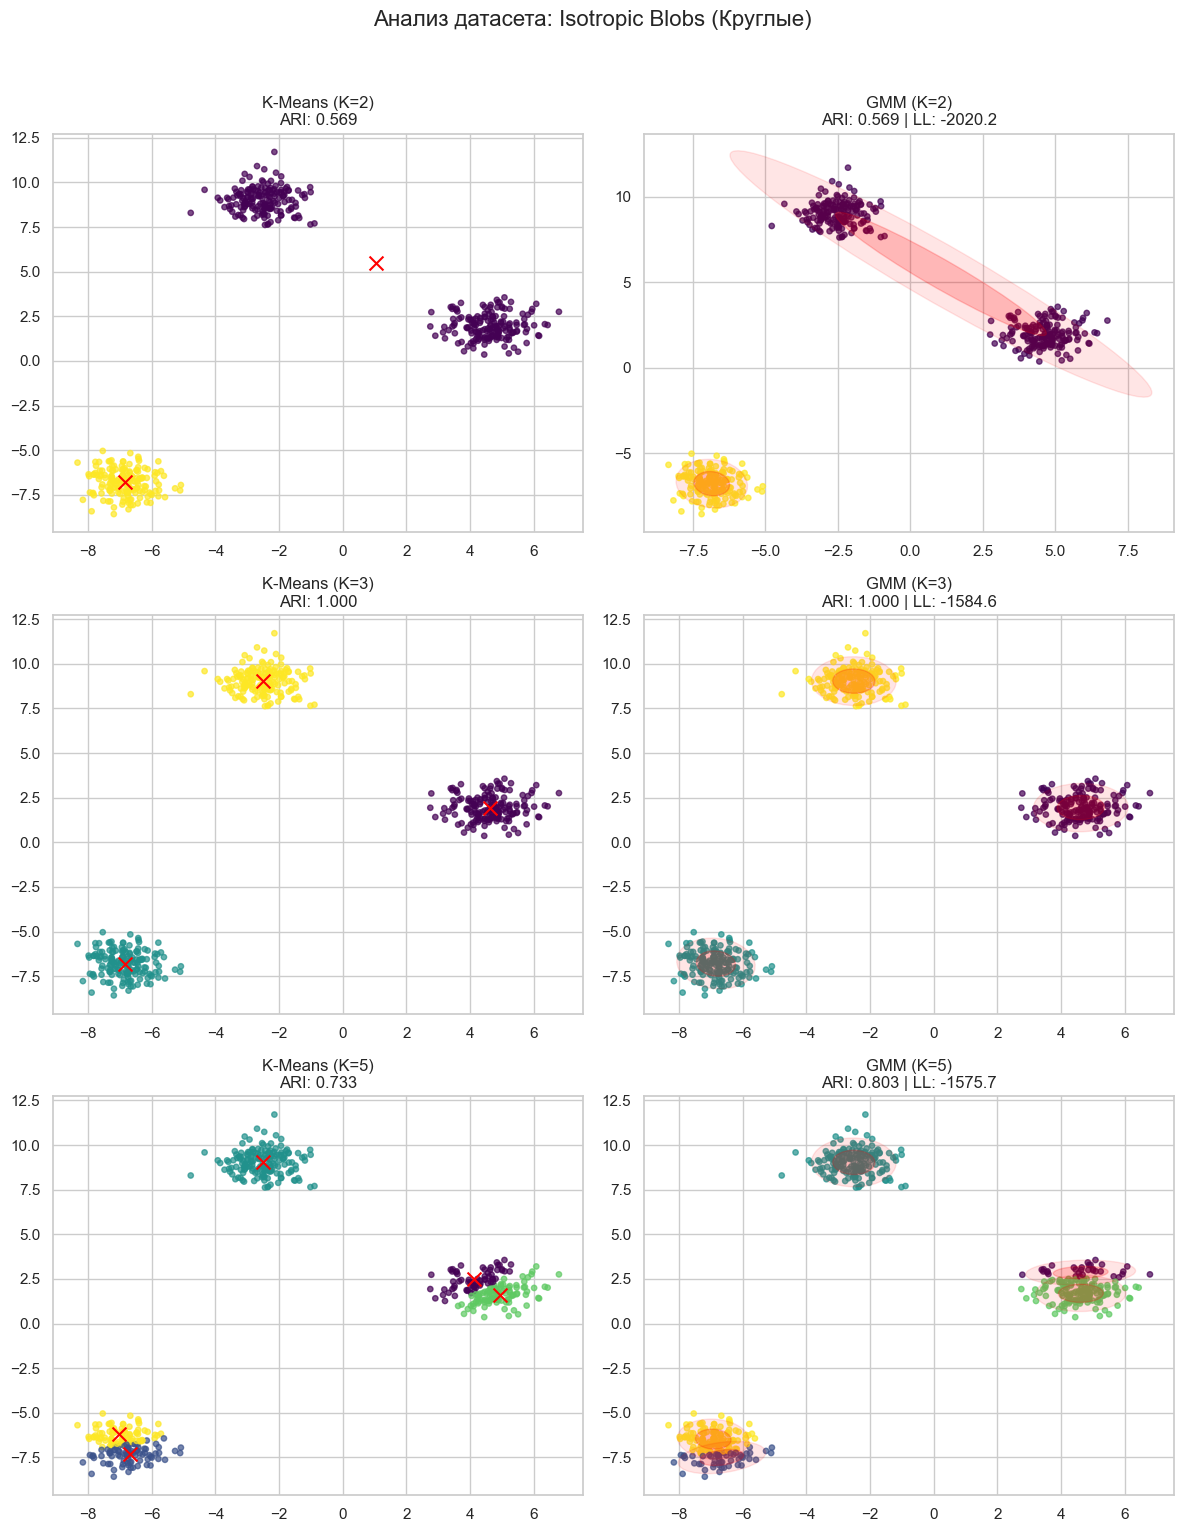

In [5]:
# Генерация данных: Идеальные круглые кластеры
X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=0.7, random_state=42)

# Список K для проверки
k_list = [2, 3, 5]

# Запуск анализа
analyze_dataset_with_k_range(X, y_true, k_list, "Isotropic Blobs (Круглые)")

Запуск для K=3...
Запуск для K=4...


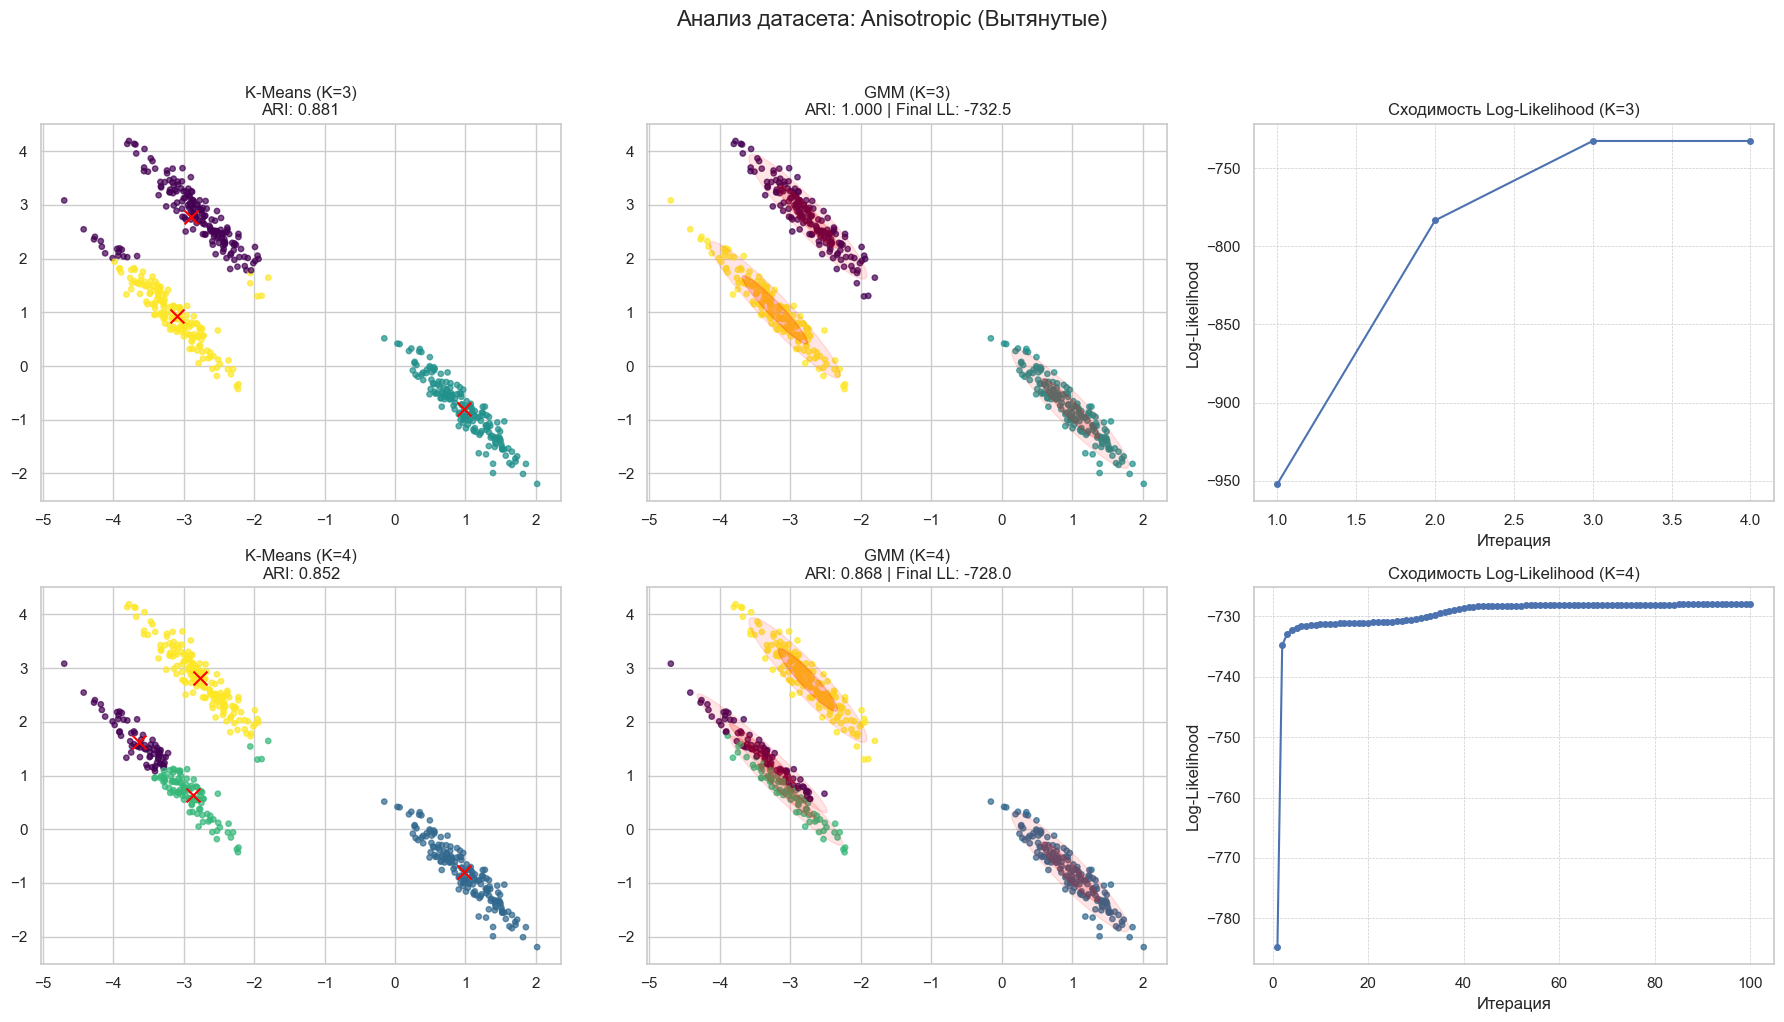

In [14]:
# Генерация данных: Вытянутые кластеры
X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X = np.dot(X, transformation)

# Список K для проверки
# Пробуем K=3 (как в истине) и K=4 (чтобы увидеть, как они делят "сосиски" лишним кластером)
k_list = [3, 4]

# Запуск анализа
analyze_dataset_with_k_range(X, y_true, k_list, "Anisotropic (Вытянутые)")

Запуск для K=3...


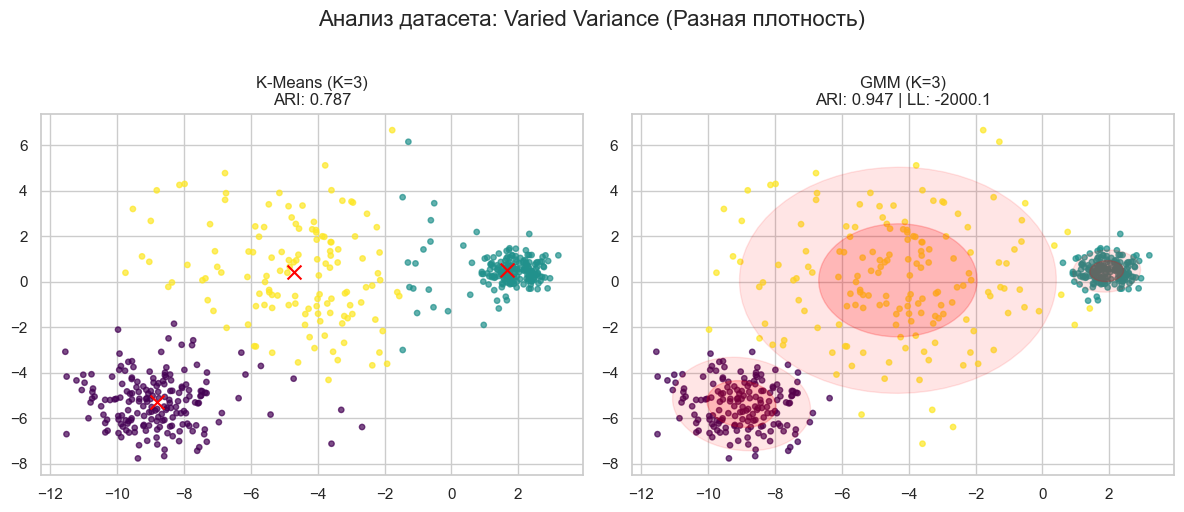

In [19]:
# Генерация данных: Разная дисперсия
X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=170)

# Список K для проверки
k_list = [3]

# Запуск анализа
analyze_dataset_with_k_range(X, y_true, k_list, "Varied Variance (Разная плотность)")

Запуск для K=2...
Запуск для K=10...


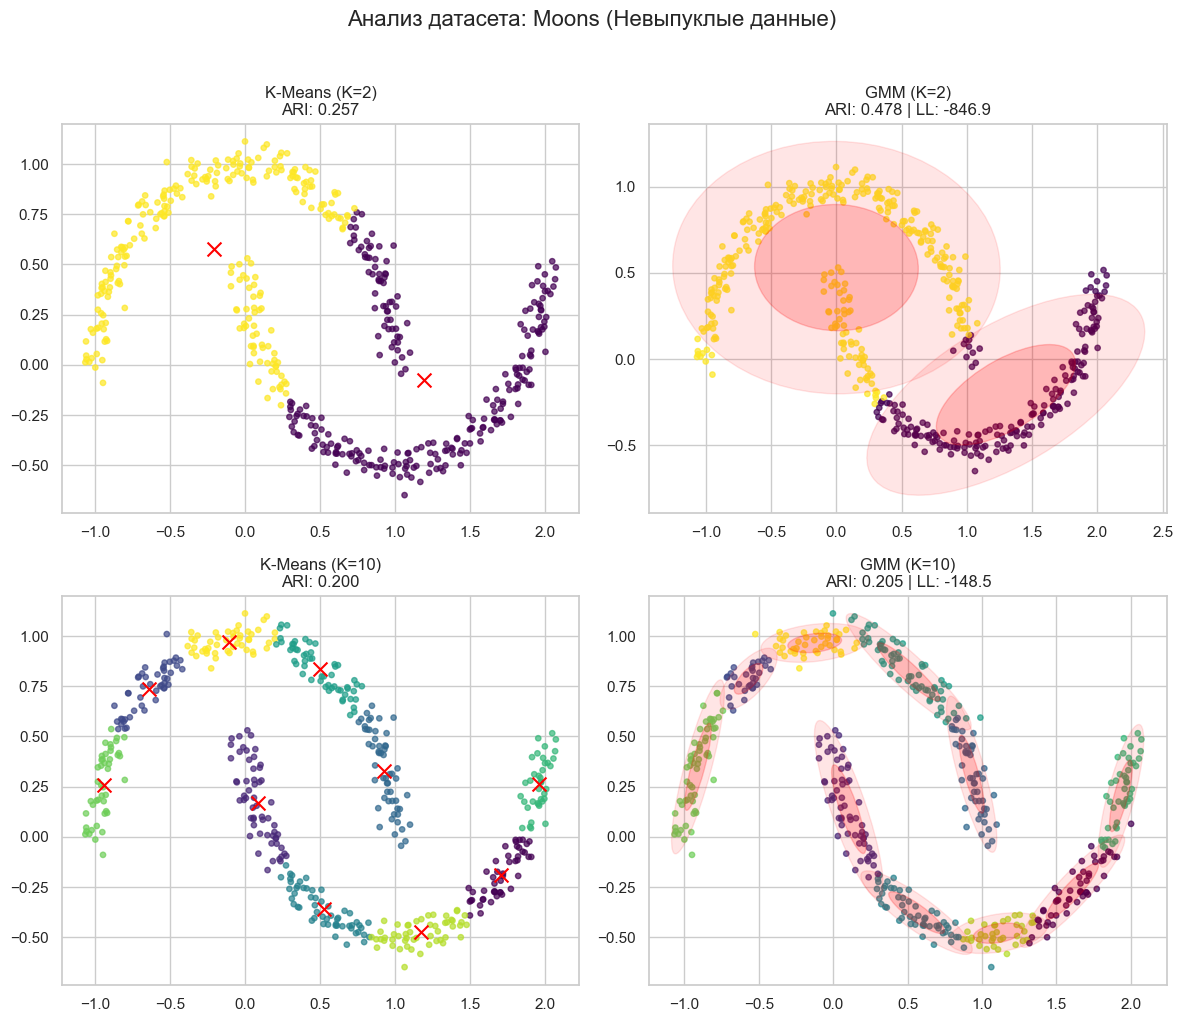

In [8]:
# Генерация данных: Луны
X, y_true = make_moons(n_samples=500, noise=0.05, random_state=0)

# Список K для проверки
# K=2: Попытка найти сами луны (провальная)
# K=10: Попытка аппроксимировать форму лун множеством эллипсов
k_list = [2, 10]

# Запуск анализа
analyze_dataset_with_k_range(X, y_true, k_list, "Moons (Невыпуклые данные)")

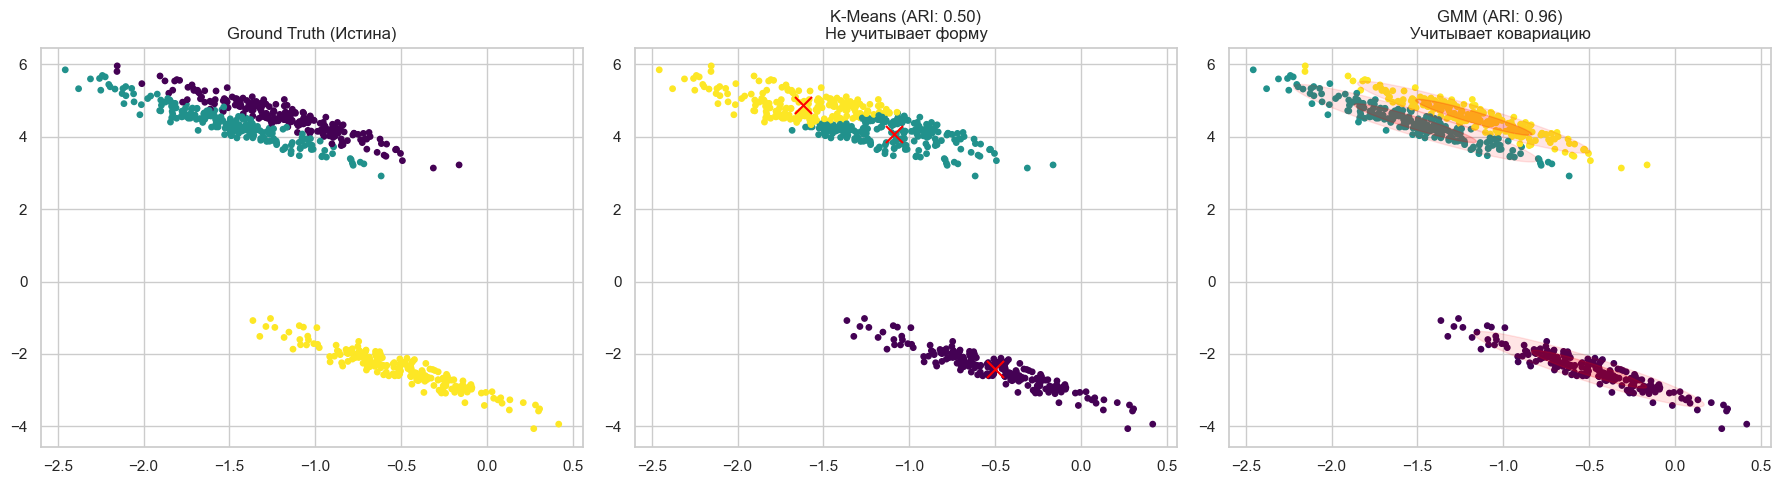

In [16]:
# Ячейка: Сравнение на сильно вытянутых данных (Исправленное)

# 1. ГЕНЕРАЦИЯ ДАННЫХ
# Берем стандартный random_state=170, который генерирует удобные для этого блобы
X, y_true = make_blobs(n_samples=600, cluster_std=0.5, random_state=171)

# Сильно растягиваем их по диагонали
transformation = [[0.60, -0.63], [-0.40, 0.85]]
X = np.dot(X, transformation)

# 2. ЗАПУСК АЛГОРИТМОВ
# K-Means
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
y_km = kmeans.fit_predict(X)
ari_km = adjusted_rand_score(y_true, y_km)

# GMM (наш класс, старт с kmeans для честности сравнения "лучшего с лучшим")
gmm = GMM(n_components=3, max_iter=100, tol=1e-4, kmeans_start=True)
gmm.fit(X)
y_gmm = gmm.predict(X)
ari_gmm = adjusted_rand_score(y_true, y_gmm)

# 3. ВИЗУАЛИЗАЦИЯ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Истина
axes[0].scatter(X[:, 0], X[:, 1], c=y_true, s=15, cmap='viridis')
axes[0].set_title("Ground Truth (Истина)")

# K-Means (Должен ошибиться)
axes[1].scatter(X[:, 0], X[:, 1], c=y_km, s=15, cmap='viridis')
# Центры
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=150)
axes[1].set_title(f"K-Means (ARI: {ari_km:.2f})\nНе учитывает форму")

# GMM (Должен справиться)
axes[2].scatter(X[:, 0], X[:, 1], c=y_gmm, s=15, cmap='viridis')
axes[2].set_title(f"GMM (ARI: {ari_gmm:.2f})\nУчитывает ковариацию")

# Рисуем эллипсы
for k in range(gmm.K):
    if gmm.weights[k] > 0.001:
        draw_ellipse(gmm.means[k], gmm.covs[k], ax=axes[2], color='red')

plt.tight_layout()
plt.show()

Запуск экспериментов со случайной инициализацией...


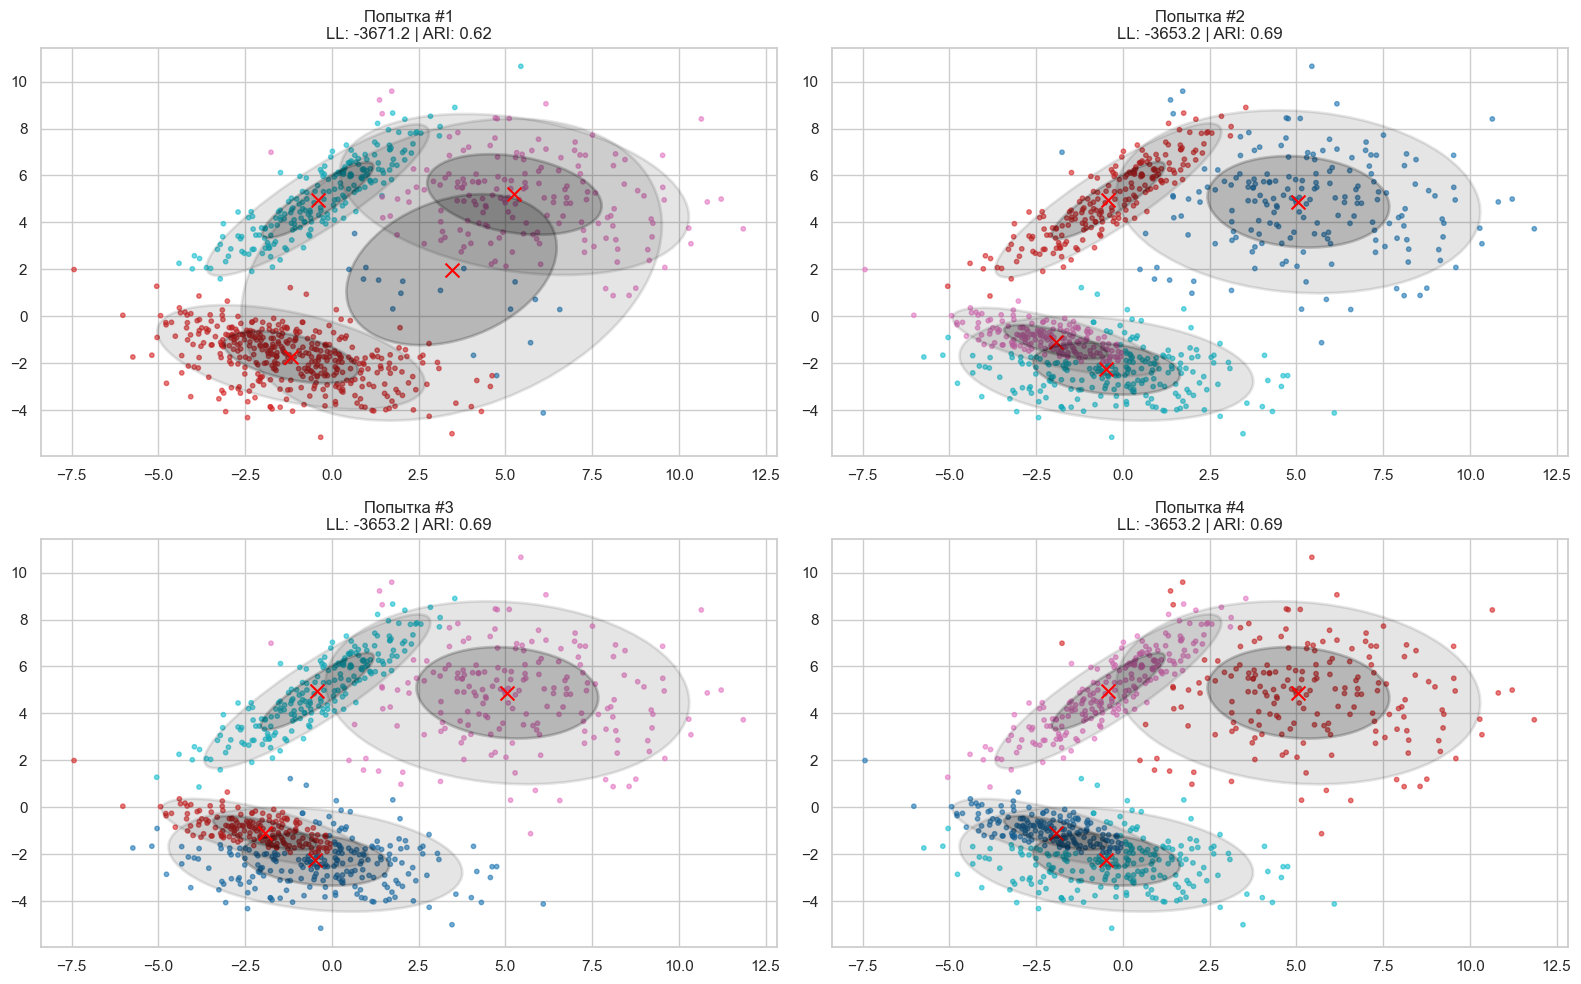

In [12]:
# Ячейка: Демонстрация нестабильности GMM (Локальные минимумы)

# 1. ГЕНЕРАЦИЯ СЛУЧАЙНЫХ ПЕРЕКРЫВАЮЩИХСЯ ЭЛЛИПСОВ
def generate_random_clusters(n_samples=800, n_clusters=4, seed=42):
    np.random.seed(seed)
    X_list = []
    y_list = []
    
    for k in range(n_clusters):
        # Случайный центр
        center = np.random.uniform(-6, 6, 2)
        
        # Случайная ковариация (создаем через поворот и растяжение)
        angle = np.random.uniform(0, 2 * np.pi)
        scale = np.diag(np.random.uniform(0.5, 2.5, 2)) # Разная ширина/длина
        rotation = np.array([[np.cos(angle), -np.sin(angle)], 
                             [np.sin(angle),  np.cos(angle)]])
        # Cov = R * S * S * R.T
        cov_matrix = rotation @ scale @ scale @ rotation.T
        
        # Генерируем точки
        points = np.random.multivariate_normal(center, cov_matrix, n_samples // n_clusters)
        X_list.append(points)
        y_list.append(np.full(len(points), k))
        
    return np.vstack(X_list), np.hstack(y_list)

# Генерируем данные (seed=42 подобран так, чтобы кластеры были близко)
X_rand, y_rand = generate_random_clusters(n_clusters=4, seed=35) 

# 2. СЕРИЯ ЗАПУСКОВ (4 попытки)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

print("Запуск экспериментов со случайной инициализацией...")

for i in range(4):
    # ВАЖНО: kmeans_start=False. Каждый раз выбираются разные случайные точки старта
    # Мы не фиксируем seed внутри GMM, чтобы каждый fit был уникальным
    model = GMM(n_components=4, max_iter=150, tol=1e-4, kmeans_start=False)
    model.fit(X_rand)
    y_pred = model.predict(X_rand)
    
    # Финальное правдоподобие (чем больше, тем лучше)
    final_ll = model.log_likelihood_history[-1]
    ari = adjusted_rand_score(y_rand, y_pred)
    
    # Рисуем
    ax = axes[i]
    ax.scatter(X_rand[:, 0], X_rand[:, 1], c=y_pred, s=10, cmap='tab10', alpha=0.6)
    
    # Эллипсы
    for k in range(model.K):
        if model.weights[k] > 0.005:
            draw_ellipse(model.means[k], model.covs[k], ax=ax, color='black', lw=2)
            # Рисуем центры, чтобы видеть, куда упала инициализация
            ax.scatter(model.means[k, 0], model.means[k, 1], c='red', marker='x', s=100)
            
    ax.set_title(f"Попытка #{i+1}\nLL: {final_ll:.1f} | ARI: {ari:.2f}")

plt.tight_layout()
plt.show()

# 6. Реальные данные

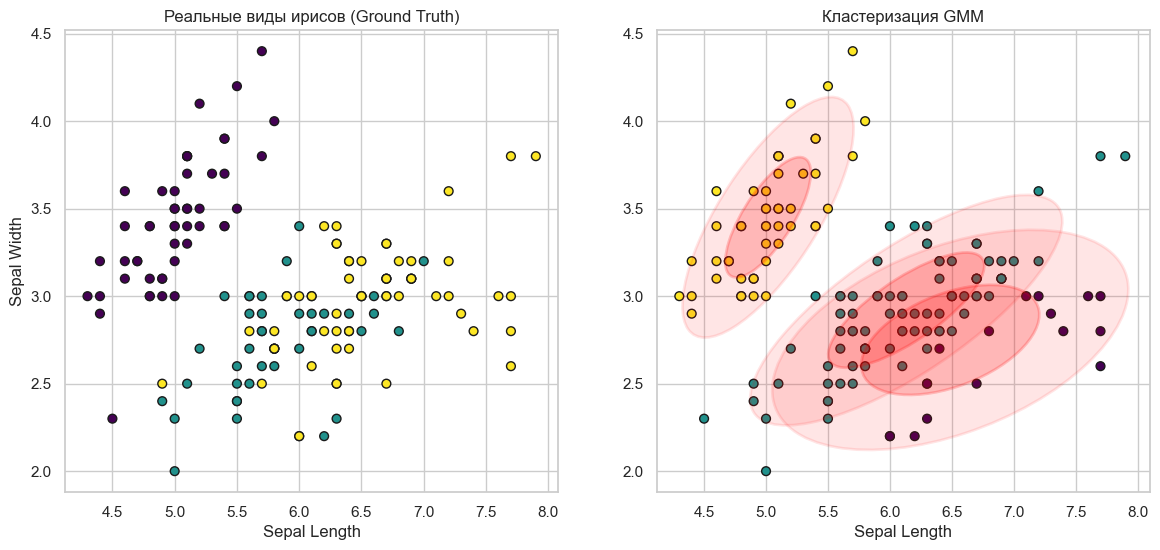

In [11]:
from sklearn.datasets import load_iris
import pandas as pd

# 1. Загружаем реальные данные (Iris)
iris = load_iris()
X_iris = iris.data[:, :2]  # Берем только первые 2 признака (длина и ширина чашелистика) для визуализации 2D
y_iris = iris.target       # Реальные виды цветов (0, 1, 2)

# 2. Запускаем твой GMM
# Мы знаем, что видов ирисов всего 3, поэтому n_components=3
gmm_iris = GMM(n_components=3, max_iter=100, tol=1e-4, kmeans_start=True)
gmm_iris.fit(X_iris)
y_pred_iris = gmm_iris.predict(X_iris)

# 3. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Реальные классы
axes[0].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='viridis', s=40, edgecolor='k')
axes[0].set_title("Реальные виды ирисов (Ground Truth)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")

# Результат GMM
axes[1].scatter(X_iris[:, 0], X_iris[:, 1], c=y_pred_iris, cmap='viridis', s=40, edgecolor='k')
axes[1].set_title("Кластеризация GMM")
axes[1].set_xlabel("Sepal Length")

# Рисуем эллипсы
for k in range(gmm_iris.K):
    if gmm_iris.weights[k] > 0.005:
        draw_ellipse(gmm_iris.means[k], gmm_iris.covs[k], ax=axes[1], color='red', lw=2)

plt.show()

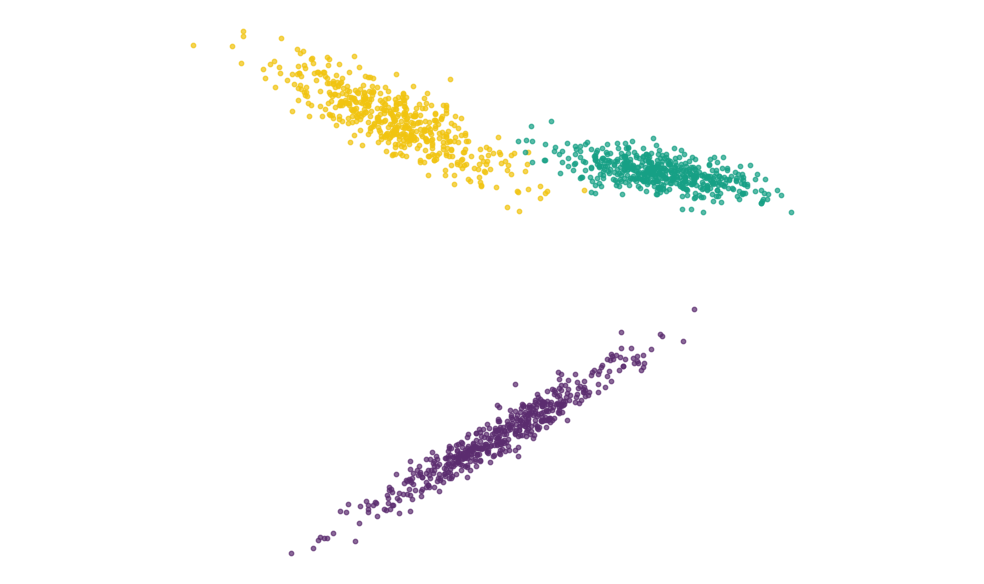

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def generate_cluster(n_samples, center, width, height, angle_degrees):
    """
    Генерирует облако точек в форме эллипса.
    
    1. Генерируем "круглый" шум.
    2. Растягиваем его (width/height).
    3. Поворачиваем на угол (angle).
    4. Сдвигаем в центр.
    """
    # 1. Генерация стандартного шума (круг)
    X = np.random.randn(n_samples, 2)
    
    # 2. Матрица масштабирования (растягиваем оси)
    # Делим на 4, чтобы width/height соответствовали примерно 4-м сигмам (95% данных)
    scale_matrix = np.array([[width / 4, 0], 
                             [0, height / 4]])
    X = X @ scale_matrix
    
    # 3. Матрица поворота
    theta = np.radians(angle_degrees)
    c, s = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([[c, -s], 
                                [s, c]])
    X = X @ rotation_matrix.T  # Транспонируем для умножения справа
    
    # 4. Сдвиг
    X += np.array(center)
    
    return X

# Параметры генерации
n = 500
np.random.seed(42) # Для воспроизводимости

# === ГЕНЕРАЦИЯ 3-х КЛАСТЕРОВ ===

# 1. Желтый: Вытянутый, наклоненный вниз (как на вашем примере сверху)
X1 = generate_cluster(n, center=(-2, 4), width=5, height=1.2, angle_degrees=-25)

# 2. Зеленый: Сильно сплюснутый, почти горизонтальный
X2 = generate_cluster(n, center=(3, 3), width=4, height=0.8, angle_degrees=-10)

# 3. Фиолетовый: Тонкий и диагональный (сильный наклон)
X3 = generate_cluster(n, center=(0, -2), width=6, height=0.7, angle_degrees=30)

# === ОТРИСОВКА ===
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(X1[:, 0], X1[:, 1], s=10, color='#F1C40F', alpha=0.7) # Желтый
plt.scatter(X2[:, 0], X2[:, 1], s=10, color='#16A085', alpha=0.7) # Бирюзовый
plt.scatter(X3[:, 0], X3[:, 1], s=10, color='#5B2C6F', alpha=0.7) # Фиолетовый

# Убираем оси и подписи для чистоты
plt.axis('equal')  # Сохраняем пропорции, чтобы эллипсы не искажались
plt.axis('off')    # Убираем рамку и цифры

plt.tight_layout()
plt.show()